In [1]:
# 2D Toy training example
# Goal: examine how the gradients change the center and sigma of a single neuron
# Conclusions: Center Gradients are correct (moves to the right center)

In [2]:
from __future__ import print_function

In [3]:
import matplotlib as mpl
# set this 'backend' when using jupyter; do this before importing pyplot
mpl.use('nbagg')
import matplotlib.pyplot as plt

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

import numpy as np
from scipy import stats

import sys
sys.path.append('/home/felix/Research/Adversarial Research/FGN---Research/')
import Finite_Gaussian_Network_lib as fgnl
import Finite_Gaussian_Network_lib.fgn_helper_lib as fgnh

In [5]:
# random seeds
# torch.manual_seed(1665)
# np.random.seed(3266)

# torch.backends.cudnn.deterministic = True
# torch.cuda.manual_seed_all(999)

In [6]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
use_cuda = False
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [7]:
# Define 2d Toy Data

# number of dimensions of the data
num_dim = 2

# gaussian target parameters
data_centers = 1*np.ones(num_dim)
sigma = 1

# hyper-plane separating the classes (this will become the target for the weights)
sep_plane = np.random.uniform(low=-1.0, high=1.0, size=num_dim)
# sep_plane = np.concatenate(([1],np.zeros(num_dim-1)))

num_samples = 1000

samples_xs = np.array([np.random.normal(loc=0, scale=sigma, size=num_dim)+data_centers for _ in range(num_samples)] )

# apply labels based on side of sep hyper plane
samples_labels = np.array([ [1] if x>np.matmul(data_centers, sep_plane) else [-1] for x in np.matmul(samples_xs, sep_plane)])

# shuffle in unison
permutation = np.random.permutation(len(samples_xs))
for old_index, new_index in enumerate(permutation):
    samples_xs[new_index] = samples_xs[old_index]
    samples_labels[new_index] = samples_labels[old_index]

<IPython.core.display.Javascript object>


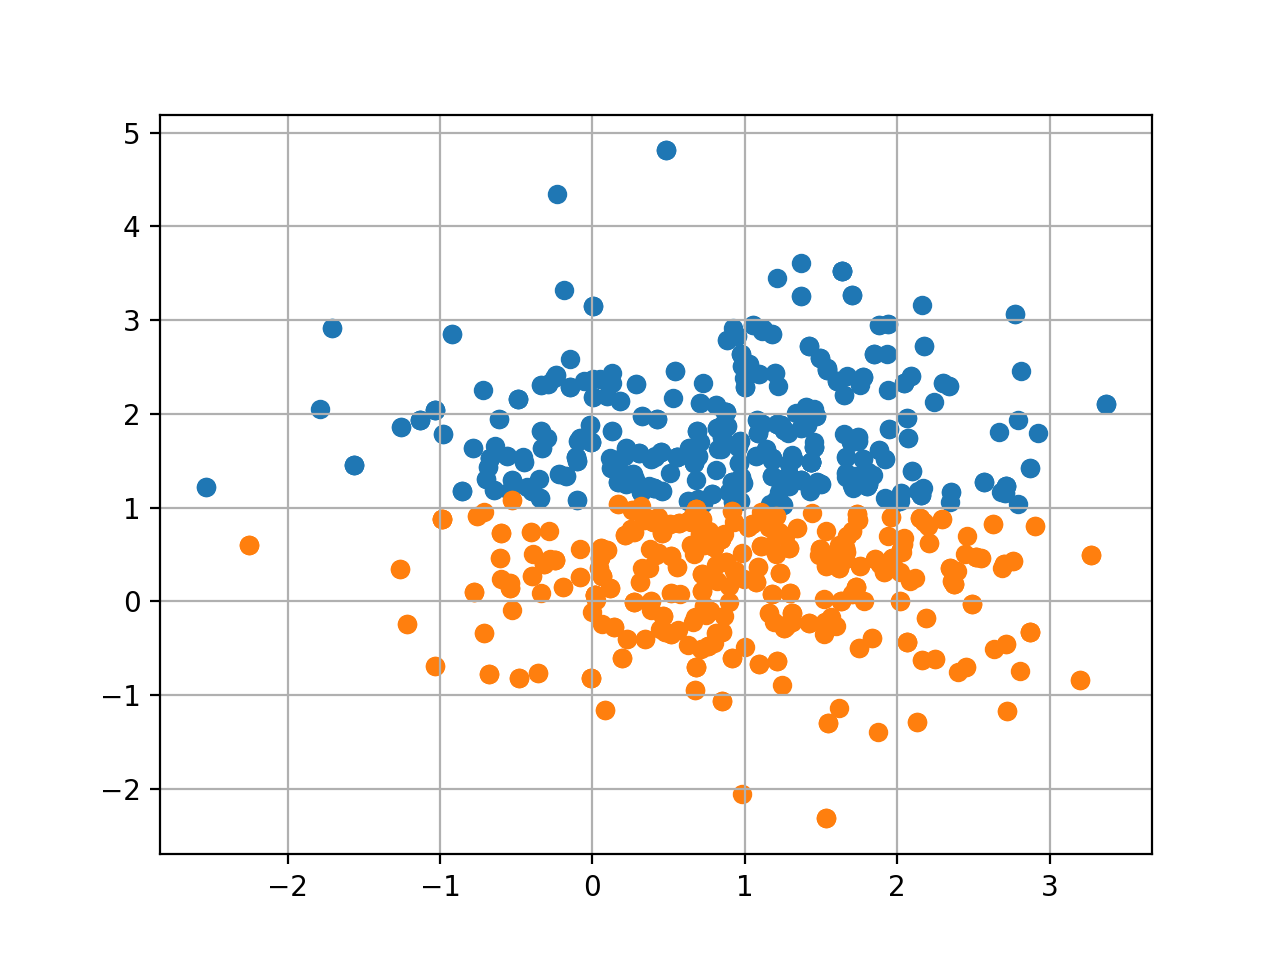

In [8]:
# 2D Check 
samples_x_1 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==1]
samples_y_1 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==1]

samples_x_2 = [x for x,l in zip(samples_xs[:,0], samples_labels) if l==-1]
samples_y_2 = [y for y,l in zip(samples_xs[:,1], samples_labels) if l==-1]


plt.scatter(samples_x_1, samples_y_1)
plt.scatter(samples_x_2, samples_y_2)
plt.grid(True)
plt.show()

In [9]:
# convert data to pytorch format 
tensor_x = torch.Tensor(samples_xs)
tensor_y = torch.Tensor(samples_labels)

my_dataset = torch.utils.data.TensorDataset(tensor_x[:num_samples*4/5],tensor_y[:num_samples*4/5]) # create your dataset
my_test_data = torch.utils.data.TensorDataset(tensor_x[num_samples*4/5:],tensor_y[num_samples*4/5:]) # create your dataset

my_dataloader = torch.utils.data.DataLoader(my_dataset, batch_size=32, shuffle=True) # create your dataloader
my_test_dataloader = torch.utils.data.DataLoader(my_test_data) # create your dataloader

In [10]:
# Define a Finite Gaussian Neural Network
class FGNet(nn.Module):
    def __init__(self):
        super(FGNet, self).__init__()
        self.l1 = fgnl.FGN_layer(2,1)

    def forward(self, x):
        x = self.l1(x)
        # clip res to +-1 for MSE loss
        x  = torch.clamp(x, min=-1.0, max=1.0)

        return x

In [11]:
# Initialize the network
model = FGNet().to(device)

In [12]:
# increase sigmas
model.l1.sigmas = torch.nn.Parameter(10.0*model.l1.sigmas)

In [13]:
# model stats
print(model)
print([p.size() for p in list(model.parameters())])
# print([p for p in list(model.parameters())])
print("Training?", model.training) 

# check sizes
print("l1")
print(model.l1.weights.size()) 
print(model.l1.centers.size()) 
print(model.l1.sigmas.size())
# print(model.l1.pis.size())

# check weights before training
print("l1")

FGNet(
  (l1): FGN_layer()
)
[torch.Size([1, 2]), torch.Size([1, 2]), torch.Size([1])]
Training? True
l1
torch.Size([1, 2])
torch.Size([1, 2])
torch.Size([1])
l1


In [14]:
model.state_dict()

OrderedDict([('l1.weights', tensor([[ 0.4253, -0.6365]])),
             ('l1.centers', tensor([[ 1.2771, -0.3801]])),
             ('l1.sigmas', tensor([10.]))])

In [15]:
# importances of the constraints
lmbda_l2 = (4.0*0.1/len(my_dataloader.dataset))
lmbda_sigs = 100.0*lmbda_l2
print(lmbda_l2)
print(lmbda_sigs)

# loss function
def loss_func(model, output, target):
    
    # normal MSE loss
    mse_loss = F.mse_loss(output, target)
    
    # sum of sigma squares loss
    sig_loss = fgnl.sigmas_loss(model)

    # l2 loss
    l2_loss = fgnh.l2_loss(model)
    
    # (old) negative log likelihood over gaussian loss
#     nllg_loss = 100.0*lmbda*torch.sum(likelihood)
#     nllg_loss = 0.0*torch.mean(likelihood)
    
    return mse_loss +lmbda_l2*l2_loss  + lmbda_sigs*sig_loss 

0.0005
0.05


In [16]:
# number of correct pred function
def pred_func(output, target):
    # (old)split output into pred and likelihoods
#     output,_ = output
    pred = torch.Tensor.sign(output)
    correct = pred.eq(target.view_as(pred)).sum().item()   
    return correct

In [17]:
# model_optimizer
# optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, momentum=0.5, nesterov=True)
# optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01)
# optimizer = optim.Adagrad(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)
optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), momentum=0.6)


In [18]:
epochs = 100
train_res = fgnh.train(model, my_dataloader, loss_func, optimizer, epochs, save_hist=2, verbose=True, pred_func=pred_func, test_loader=my_test_dataloader)

Epoch 0 Train set - Average loss: 4.7630, Accuracy: 556/800 (70%)
Test set - Average loss: 3.5661, Accuracy: 173/200 (86%)
Epoch 1 Train set - Average loss: 3.0538, Accuracy: 775/800 (97%)
Test set - Average loss: 2.6471, Accuracy: 196/200 (98%)
Epoch 2 Train set - Average loss: 2.3489, Accuracy: 784/800 (98%)
Test set - Average loss: 2.0808, Accuracy: 199/200 (100%)
Epoch 3 Train set - Average loss: 1.8652, Accuracy: 792/800 (99%)
Test set - Average loss: 1.6702, Accuracy: 197/200 (98%)
Epoch 4 Train set - Average loss: 1.5015, Accuracy: 789/800 (99%)
Test set - Average loss: 1.3421, Accuracy: 199/200 (100%)
Epoch 5 Train set - Average loss: 1.2043, Accuracy: 791/800 (99%)
Test set - Average loss: 1.0804, Accuracy: 197/200 (98%)
Epoch 6 Train set - Average loss: 0.9696, Accuracy: 795/800 (99%)
Test set - Average loss: 0.8661, Accuracy: 199/200 (100%)
Epoch 7 Train set - Average loss: 0.7756, Accuracy: 794/800 (99%)
Test set - Average loss: 0.6922, Accuracy: 199/200 (100%)
Epoch 8 Trai

Test set - Average loss: 0.2150, Accuracy: 197/200 (98%)
Epoch 66 Train set - Average loss: 0.2133, Accuracy: 794/800 (99%)
Test set - Average loss: 0.2114, Accuracy: 199/200 (100%)
Epoch 67 Train set - Average loss: 0.2108, Accuracy: 798/800 (100%)
Test set - Average loss: 0.2120, Accuracy: 199/200 (100%)
Epoch 68 Train set - Average loss: 0.2097, Accuracy: 795/800 (99%)
Test set - Average loss: 0.2112, Accuracy: 199/200 (100%)
Epoch 69 Train set - Average loss: 0.2117, Accuracy: 797/800 (100%)
Test set - Average loss: 0.2134, Accuracy: 199/200 (100%)
Epoch 70 Train set - Average loss: 0.2110, Accuracy: 794/800 (99%)
Test set - Average loss: 0.2105, Accuracy: 199/200 (100%)
Epoch 71 Train set - Average loss: 0.2101, Accuracy: 795/800 (99%)
Test set - Average loss: 0.2137, Accuracy: 200/200 (100%)
Epoch 72 Train set - Average loss: 0.2103, Accuracy: 797/800 (100%)
Test set - Average loss: 0.2116, Accuracy: 199/200 (100%)
Epoch 73 Train set - Average loss: 0.2106, Accuracy: 796/800 (100

In [19]:
# print model state_dict post training
model.state_dict()

OrderedDict([('l1.weights', tensor([[0.1538, 8.1873]])),
             ('l1.centers', tensor([[0.9206, 0.9653]])),
             ('l1.sigmas', tensor([1.4434]))])

<IPython.core.display.Javascript object>


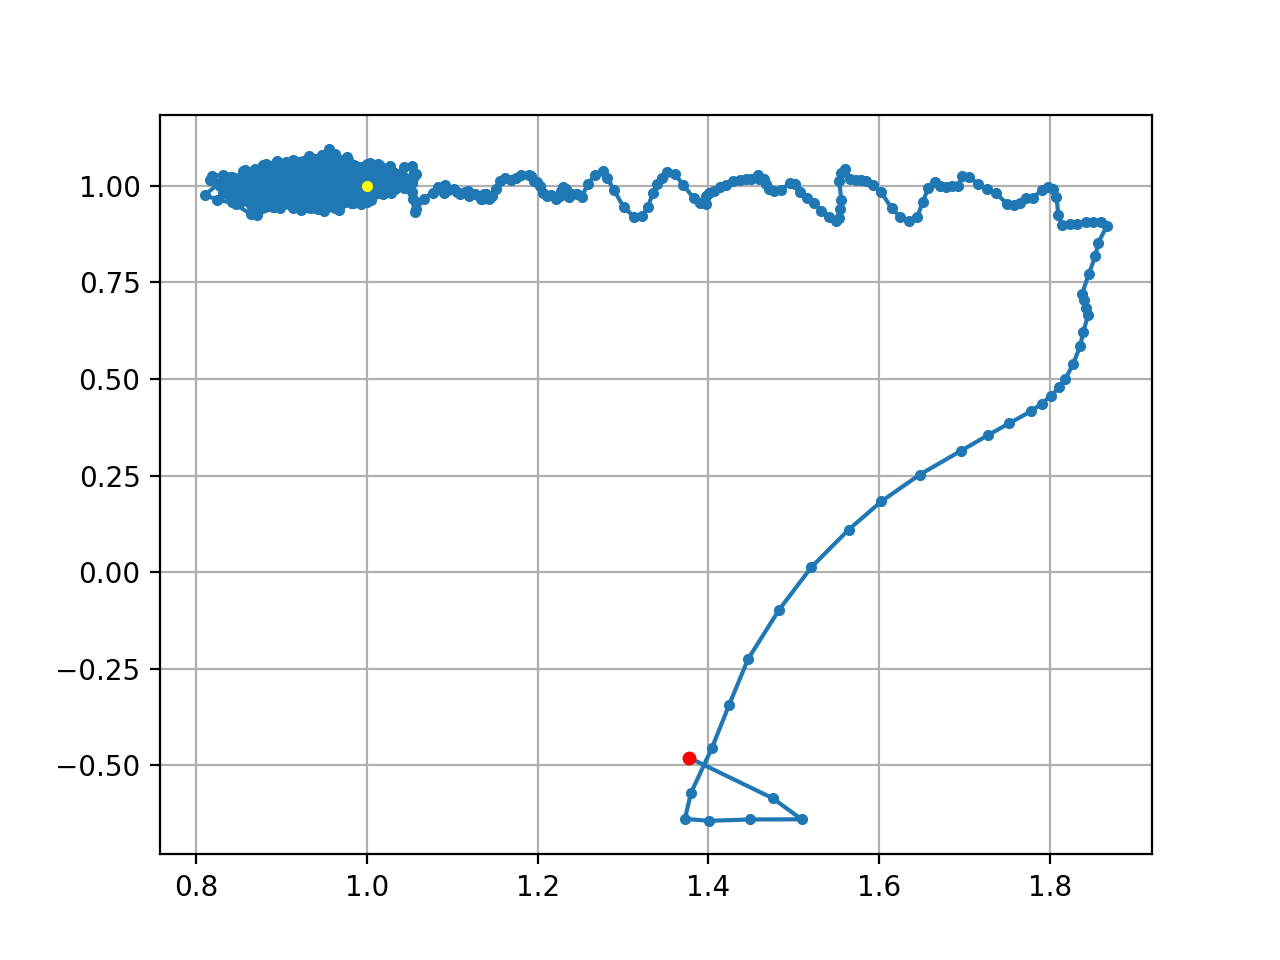

In [20]:
# compare center with target (1,1)

x, y = zip(*train_res['histories']['l1.centers'][:,0,:])
plt.plot(x,y, marker='.', linestyle='-')

# plot start
x,y = train_res['histories']['l1.centers'][0,0,:]
plt.plot(x,y, marker='o', markersize=4, color="red")
# plot target
x, y = 1,1
plt.plot(x,y, marker='.', linestyle='-', color="yellow")

# plt.axis([-3,3, -3, 3])
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


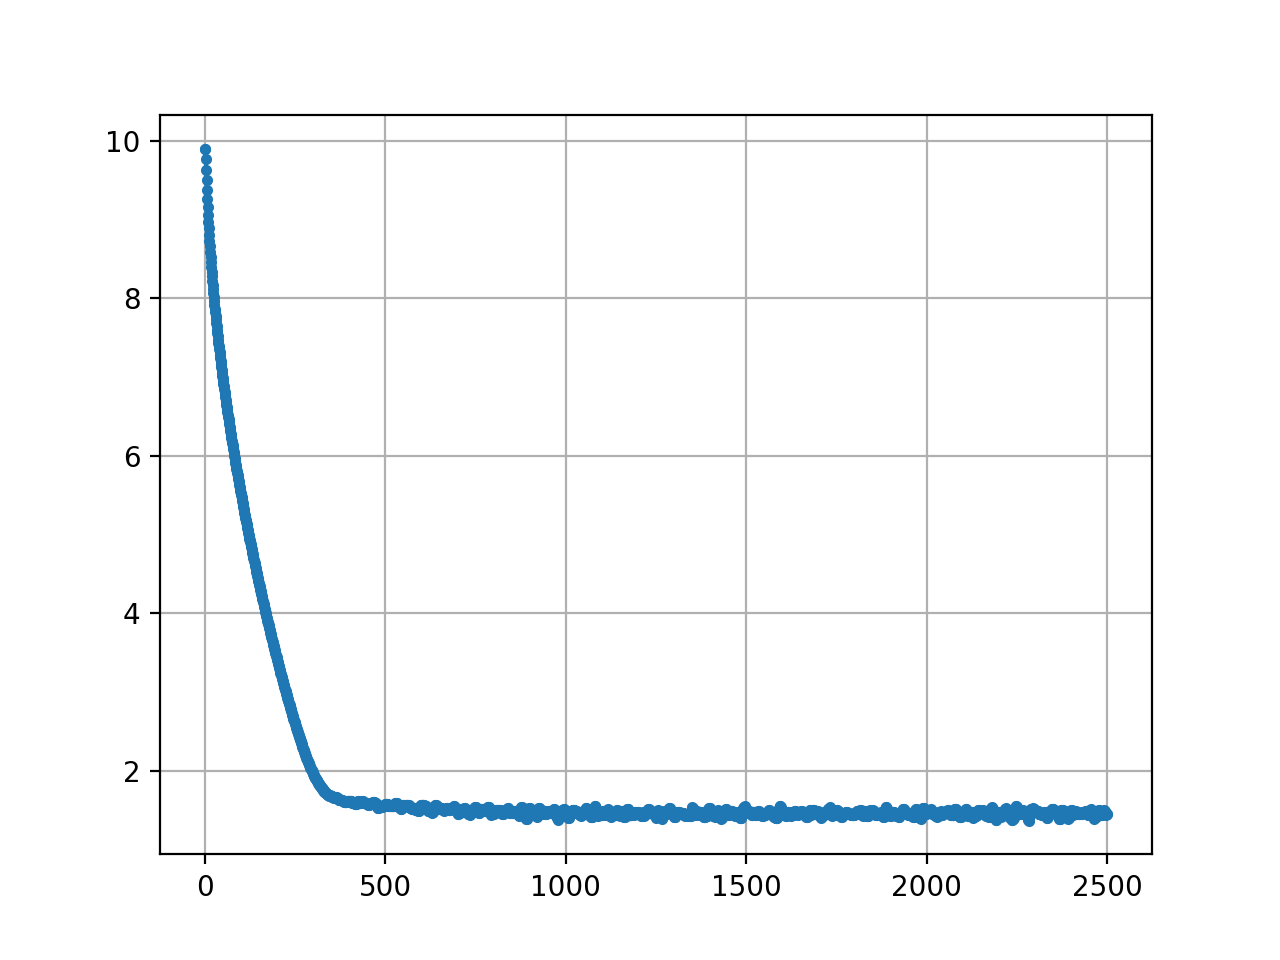

In [21]:
# plot sigma history
plt.plot(train_res['histories']['l1.sigmas'][:,0], marker='.', linestyle='-')
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


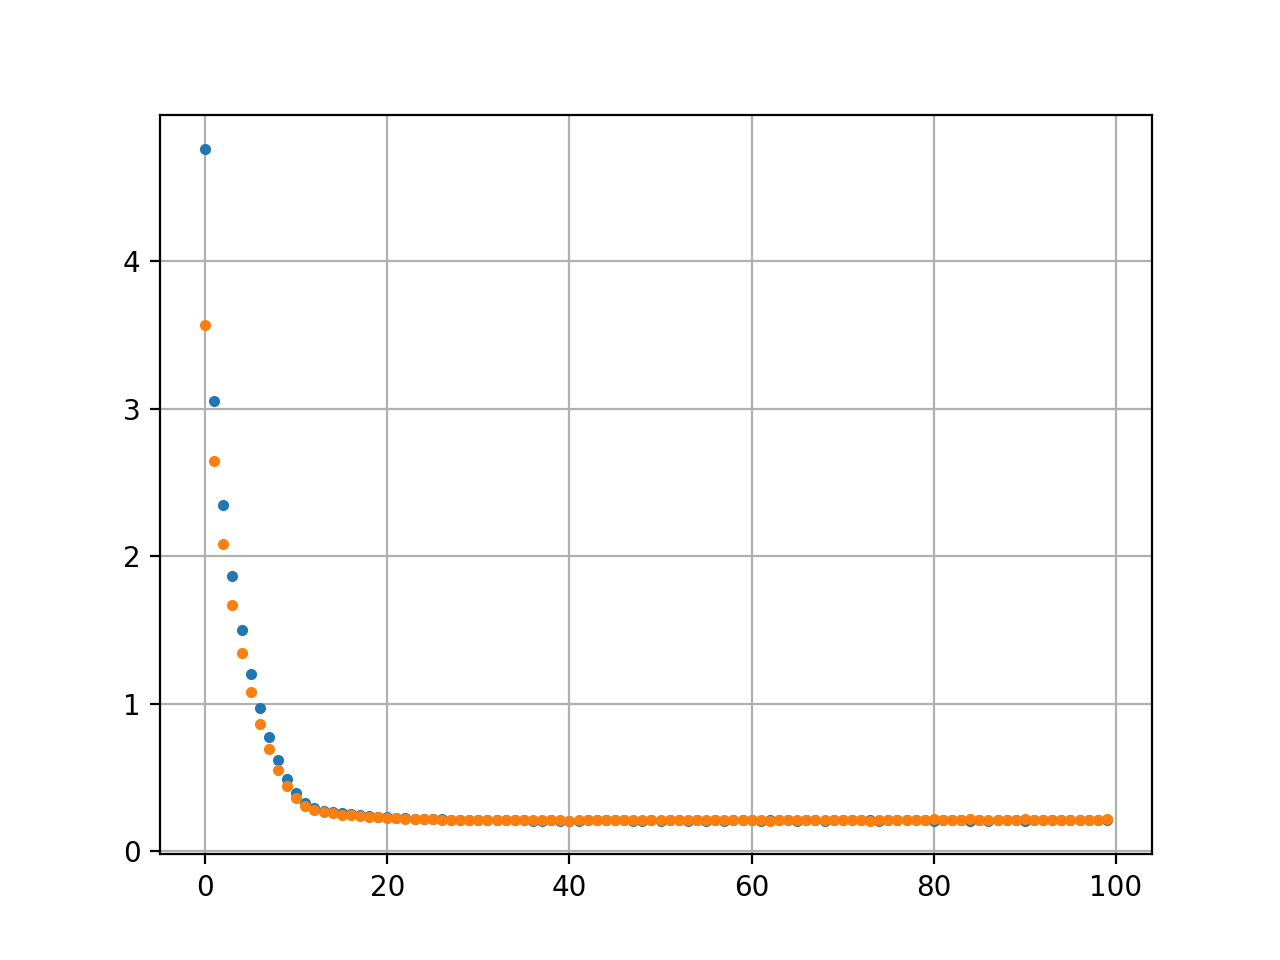

<IPython.core.display.Javascript object>


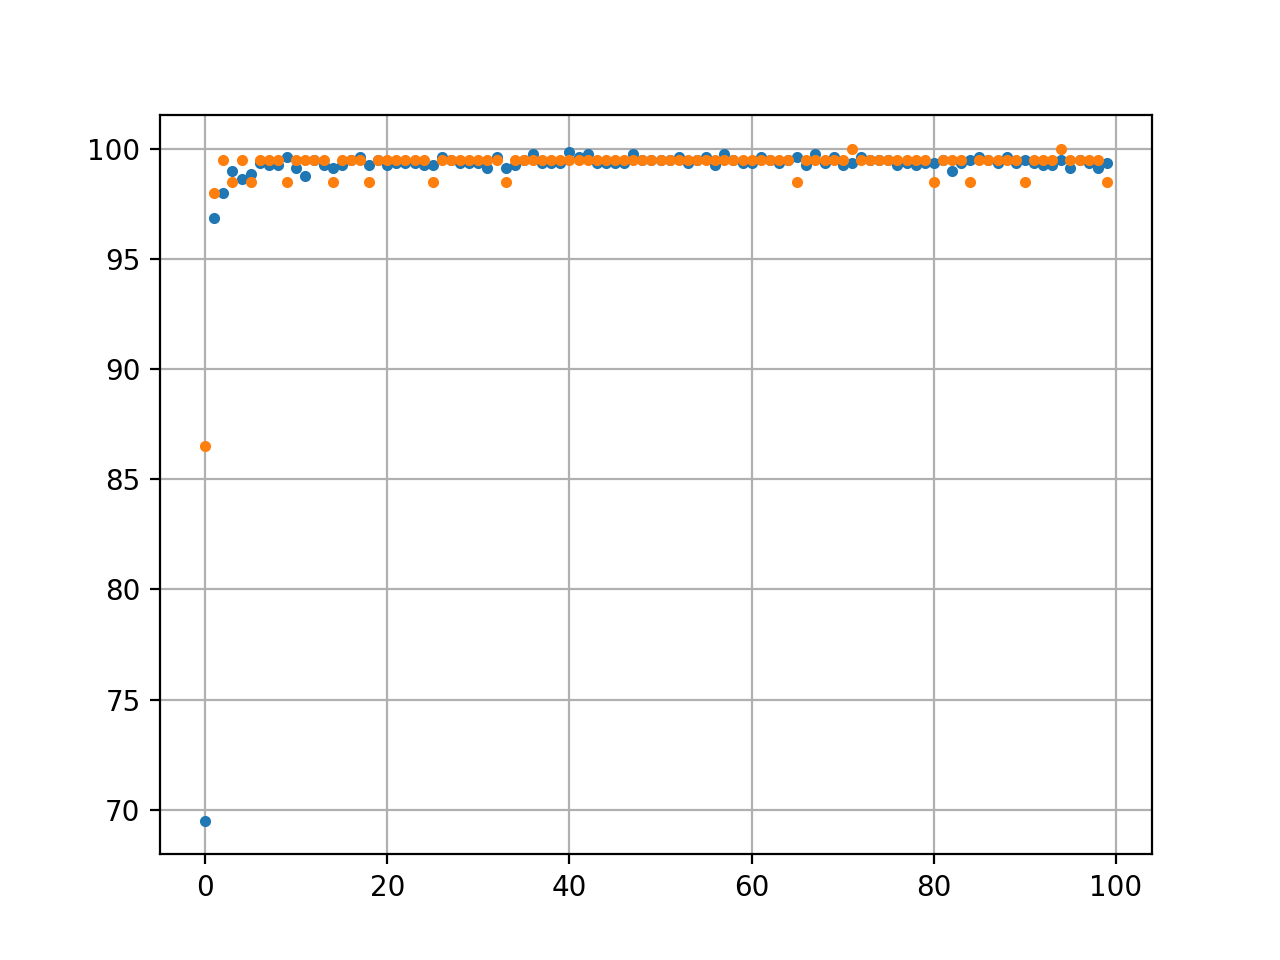

In [22]:
# acc and loss hist
plt.plot(train_res['train_loss_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_loss_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

plt.plot(train_res['train_acc_hist'], marker='.', linestyle=' ')
plt.plot(train_res['test_acc_hist'], marker='.', linestyle=' ')
plt.grid()
plt.show()

weights: [0.15379637 8.187299  ]
center: [0.9205656  0.96526957]
sig: 1.4434025
bias: -8.04453


<IPython.core.display.Javascript object>


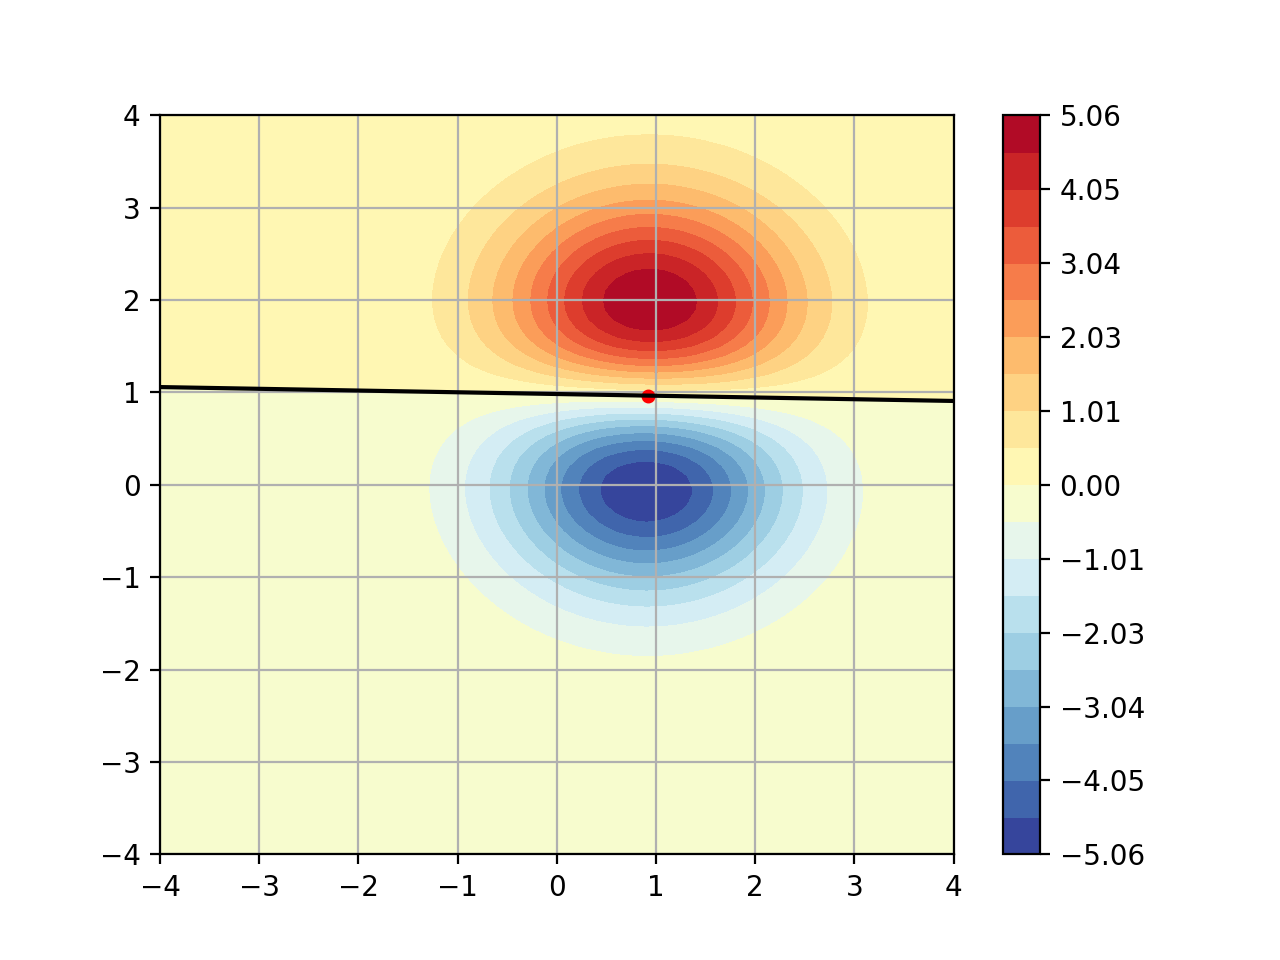

In [23]:
# visualize neuron activity over data

from matplotlib import cm
# scale of the heat maps
X1 = np.arange(-4,4.1, 0.1)
X2 = np.arange(-4,4.1, 0.1)
X1s, X2s = np.meshgrid(X1,X2)
inputs_heatmap = np.reshape(zip(X1s.flatten(),X2s.flatten()),(-1,2))

# combining circular gaussian with normal neuron
# neuron parameters (weights, bias)
W = model.l1.weights.detach().numpy()[0]
print("weights:",W)
# b = 0 # bias defined by by the center of radial function

# radial parameters
center = model.l1.centers.detach().numpy()[0] # controls the center of gaussian (<=> bias of neuron)
# plot center as red dot
plt.plot(center[0], center[1], marker='o', markersize=4, color="red")

print("center:",center)
sig = model.l1.sigmas.detach().numpy()[0] # controls the size of the gaussian
print("sig:",sig)
b = -np.matmul(W,center)
print("bias:",b)
# new zero line
zero_line = -(W[0]*X1+b)/W[1]

# heatmap neuronal activity
n_activity = np.sum(W*inputs_heatmap, axis=1)+b
# print(n_activity.shape)

# heatmap radial activity 

r_activity = np.exp((-1.0/sig**2) *  np.sum(np.square(inputs_heatmap-center), axis=1))
# print(r_activity.shape)

# overall heatmap activity
activity = n_activity*r_activity

# plot the zero line
plt.plot(X1,zero_line, color='black')
# plot the heatmap 
maxi = np.max(activity)
levels = np.arange(-maxi,maxi+0.1,maxi/10.0)
ticks = np.arange(-maxi,maxi+1, maxi/5.0)


plt.contourf(X1s, X2s, np.reshape(activity, np.shape(X1s) ), levels=levels, cmap=cm.RdYlBu_r)

plt.colorbar(ticks=ticks)
#reset axes
plt.axis([-4,4, -4, 4])
plt.grid(True)
plt.show()